In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from connect_to_database import get_data_from_db

We are gathering data for 30 legendary rock artists in a cloud database (you can find more information about the E.T.L process here; https://github.com/VangelisChocholis/ETL_Spotify_data). The ultimate objective is to create a Streamlit web application that provides real-time visualizations of popularity and trends based on the collected data. Before proceeding with the construction of the web app, it is crucial to conduct Exploratory Data Analysis (EDA).

Read the data (use `get_data_from_db` to get data instead of pd.read_csv)

In [3]:
# read static data
artists_table = pd.read_csv('artists_table.csv')
albums_table = pd.read_csv('albums_table.csv')
tracks_table = pd.read_csv('tracks_table.csv')
tracks_faeaures_table = pd.read_csv('tracks_features_table.csv')
# read dynamic data
tracks_popularity_table = pd.read_csv('tracks_popularity_table.csv', parse_dates=['date'])
albums_popularity_table = pd.read_csv('albums_popularity_table.csv', parse_dates=['date'])
artists_popularity_table = pd.read_csv('artists_popularity_table.csv', parse_dates=['date'])
artists_followers_table = pd.read_csv('artists_followers_table.csv', parse_dates=['date'])

In [4]:
# merge to get tracks data
data = pd.merge(tracks_table, albums_table, on='album_id')
data = pd.merge(data, artists_table, on='artist_id')
# get the last date of popularity
data = pd.merge(data, tracks_popularity_table.query('date == @tracks_popularity_table.date.max()'), on='track_id')
data = pd.merge(data, tracks_faeaures_table, on='track_id')


#artists = pd.merge(artists_table, artists_popularity_table, on='artist_id')
#artists = pd.merge(artists, artists_followers_table[['artist_id', 'followers']], on='artist_id')

In [5]:
data.columns

Index(['track_id', 'album_id', 'track_name', 'track_duration_ms',
       'track_spotify_url', 'track_preview_url', 'track_duration_display',
       'original_track_name', 'artist_id', 'album_name', 'album_release_date',
       'album_total_tracks', 'album_image_large', 'album_image_medium',
       'album_image_small', 'original_album_name', 'artist_name', 'date',
       'track_popularity', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'danceability', 'energy', 'track_key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type'],
      dtype='object')

In [6]:
# drop unnecessary columns
data = data.drop(['track_spotify_url', 'track_preview_url', 'album_image_large', 
                  'album_image_medium', 'album_image_small',
                  'uri', 'analysis_url', 'track_href', 'duration_ms'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   track_id                5956 non-null   object        
 1   album_id                5956 non-null   object        
 2   track_name              5956 non-null   object        
 3   track_duration_ms       5956 non-null   int64         
 4   track_duration_display  5956 non-null   object        
 5   original_track_name     5956 non-null   object        
 6   artist_id               5956 non-null   object        
 7   album_name              5956 non-null   object        
 8   album_release_date      5956 non-null   int64         
 9   album_total_tracks      5956 non-null   int64         
 10  original_album_name     5956 non-null   object        
 11  artist_name             5956 non-null   object        
 12  date                    5956 non-null   datetime

In [8]:
# check for missing values
data.isna().sum(axis=0)

track_id                  0
album_id                  0
track_name                0
track_duration_ms         0
track_duration_display    0
original_track_name       0
artist_id                 0
album_name                0
album_release_date        0
album_total_tracks        0
original_album_name       0
artist_name               0
date                      0
track_popularity          0
time_signature            0
danceability              0
energy                    0
track_key                 0
loudness                  0
mode                      0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
type                      0
dtype: int64

In [9]:
# convert duration to seconds
data['track_duration_sec'] = data['track_duration_ms']/1000
data = data.drop('track_duration_ms', axis=1)

In [10]:
data.describe()

,album_release_date,album_total_tracks,date,track_popularity,time_signature,danceability,energy,track_key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_duration_sec
count,5956.000000,5956.000000,5956,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000,5956.000000
mean,1988.912021,16.477166,2024-01-10 00:00:00.000000256,35.034251,3.892713,0.493097,0.634537,5.251007,-9.485259,0.739590,0.061575,0.261318,0.142479,0.214232,0.528509,122.277366,236.079101
min,1962.000000,5.000000,2024-01-10 00:00:00,0.000000,0.000000,0.000000,0.002940,0.000000,-38.575000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,4.066000
25%,1973.000000,11.000000,2024-01-10 00:00:00,23.000000,4.000000,0.391750,0.460750,2.000000,-11.621250,0.000000,0.031900,0.014500,0.000021,0.098300,0.330000,101.200500,175.333000
50%,1986.000000,13.000000,2024-01-10 00:00:00,34.000000,4.000000,0.498000,0.671000,5.000000,-8.709000,1.000000,0.039600,0.127000,0.002280,0.142000,0.532000,121.355500,227.526500
75%,2003.250000,19.000000,2024-01-10 00:00:00,46.000000,4.000000,0.597250,0.843000,9.000000,-6.222250,1.000000,0.058300,0.460250,0.113000,0.284000,0.733000,139.361500,280.478500
max,2023.000000,45.000000,2024-01-10 00:00:00,90.000000,5.000000,0.939000,1.000000,11.000000,-0.251000,1.000000,0.959000,0.994000,0.999000,0.993000,0.982000,216.304000,1758.306000
std,18.075910,8.602598,NaN,16.676660,0.419596,0.146110,0.243125,3.517015,4.676350,0.438895,0.084681,0.292752,0.269505,0.179638,0.252622,28.980473,103.789258


Here are some notable observations from the `describe()` table, and also information about each column. Inforamtion about the audio features can be found in the Sotify's API documentation (https://developer.spotify.com/documentation/web-api/reference/get-audio-features):

- `album_total_tracks`: the max number is 45, which is quite large

- `track_popularity`: The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. We can see that 75% of tracks have a popularity score below 46, with only 25% achieving some level of popularity.

- `time_signature`: The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". We have minumum of 0 which is invalid. More than 75% of tracks has time signature "4/4",  something to be expected for the rock genre.

- `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. The average track lies in the middle, with the median and mean danceability being around 0.5.

- `energy`: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. We can see that 50% of the tracks have energy levels exceeding 0.67, leading to the conclusion that our Rock artists generally produce energetic songs.

- `track_key`: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1 (Range: -1 - 11). This is a categorical feature. We will tranform this column later.

- `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. 

- `mode`: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. We will tranform this column later.

- `speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 75 % of tracks do not contain any spoken words.

- `accousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The average track is not accoustic. However, 25% of tracks have an accousticness value of 0.46, increasing the likelihood that these tracks are accoustic.

- `instrumentalness`: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. We can see that 50 % of tracks have nearly zero instumentalness value.

- `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 50% of tracks have a liveness value of 0.14.

- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). Approximately 50% of tracks exhibit a slight 'positive' valence.

- `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. The average track has a tempo of 120 BPM which is the most common tempo in all of music, and is considered Allegro (brisk and lively.) It's a little fast, but not that much.

- `track_duration_sec`: The average track duration is arround 230 seconds.

We must handle `track_key` and `mode` which are categorical variables.

For `track_key`

In [11]:
# convert mode from 1/0 to major/minor
data['mode'] = np.where(data['mode']==1, 'major', 'minor')
data['mode'].head()

0    major
1    major
2    minor
3    minor
4    minor
Name: mode, dtype: object

For the mode we create a dictionary with musical notes and the corresponding number.

In [12]:
musical_notes = {
    -1: None,
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

# map musical notes to key
data['track_key'] = data['track_key'].map(musical_notes)
data['track_key'].head()

0    C
1    D
2    F
3    B
4    F
Name: track_key, dtype: object

We explore `track_key` distributution.

In [13]:
# check for None
data[data['track_key']==None].shape[0]

0

In [14]:
data['track_key'].value_counts()

track_key
A     952
D     891
G     791
C     724
E     616
B     420
F     403
C#    335
G#    245
F#    239
A#    220
D#    120
Name: count, dtype: int64

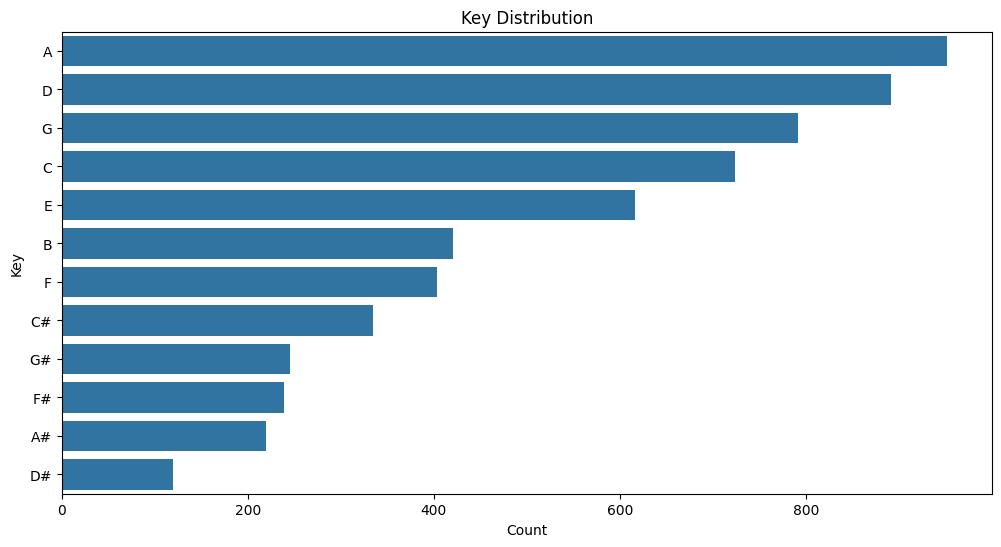

In [15]:
# plot key distribution
plt.figure(figsize=(12,6))
sns.countplot(data['track_key'], order=data['track_key'].value_counts().index)
plt.title('Key Distribution')
plt.xlabel('Count')
plt.ylabel('Key')
plt.show()


Most of the tracks are written in "A" and "D", followed by "G", "C" and "E". Later on, we will investigate the relationship between `track_key` and other features.

Popularity and Key;

We explore `mode` distribution.

In [16]:
data['mode'].value_counts(normalize=True)

mode
major    0.73959
minor    0.26041
Name: proportion, dtype: float64

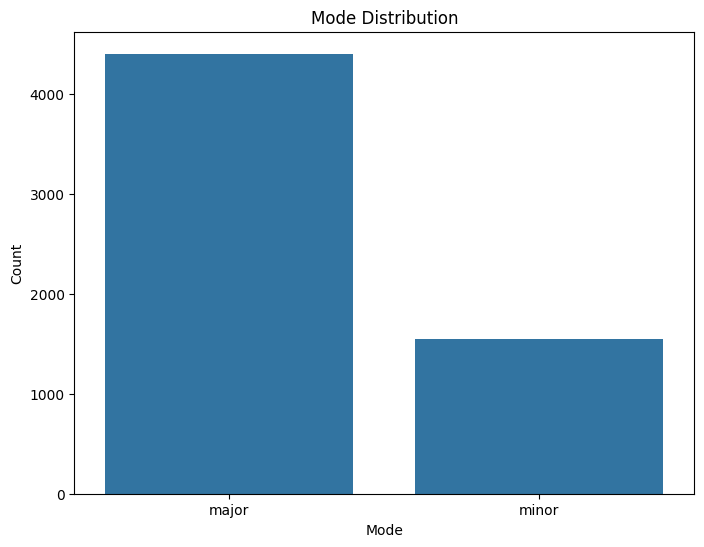

In [17]:
# plot mode distribution
plt.figure(figsize=(8,6))
sns.barplot(y=data['mode'].value_counts().values, x=data['mode'].value_counts().index)
plt.title('Mode Distribution')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.show()


74% of tracks are written in a "major" scale.

Mode and Popularity

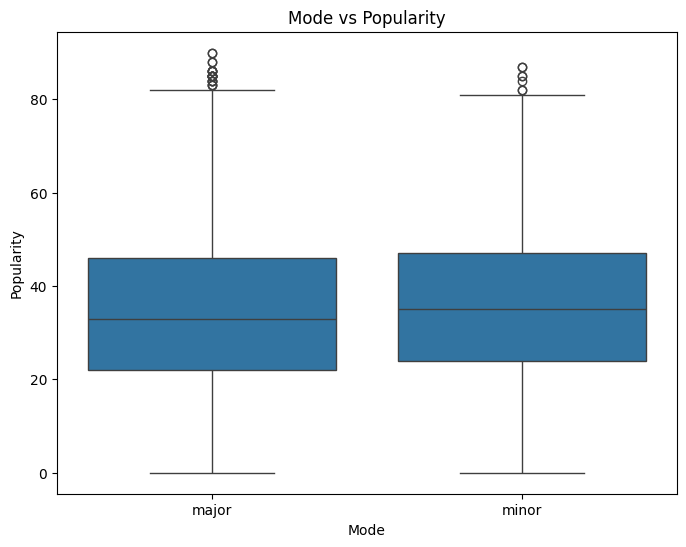

In [18]:
# plot relation between mode and popularity
plt.figure(figsize=(8,6))
sns.boxplot(x=data['mode'], y=data['track_popularity'])
plt.title('Mode vs Popularity')
plt.xlabel('Mode')
plt.ylabel('Popularity')
plt.show()



There is no significant difference between major and minor scale when we inlcude all the tracks. However, we must investigate tracks with high popularity. We will make boxplots for the top 5% popular traks.

In [19]:
# find the 95th percentile of popularity
data['track_popularity'].quantile(0.95)

65.0

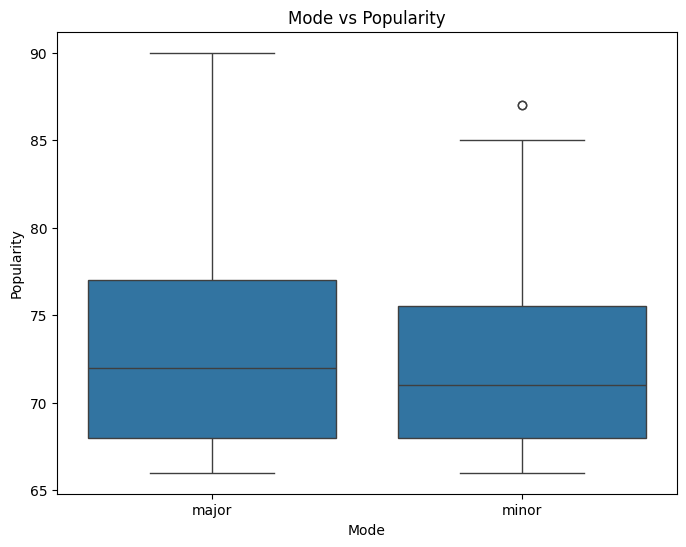

In [20]:
# plot relation between mode and popularity
plt.figure(figsize=(8,6))
sns.boxplot(x=data['mode'], y=data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['track_popularity'])
plt.title('Mode vs Popularity')
plt.xlabel('Mode')
plt.ylabel('Popularity')
plt.show()


There is not statistical difference between the two scales

In [21]:
# make hypothesis test to check if there is a significant difference between the two modes
major = data.query('mode == "major" & track_popularity > @data["track_popularity"].quantile(0.95)')['track_popularity']
minor = data.query('mode == "minor" & track_popularity > @data["track_popularity"].quantile(0.95)')['track_popularity']
p_value = stats.ttest_ind(major, minor)[1]
print(f"p value is: {p_value}")
if p_value < 0.05:
    print('There is a significant difference between the two modes')
else:
    print('There is no significant difference between the two modes')

p value is: 0.3633837700254876
There is no significant difference between the two modes


Explore `time_signature` distribution.

In [22]:
# convert time signature to string with proper format
data['time_signature'] = data['time_signature'].apply(lambda x: str(x) + "/" + "4")

In [23]:
data['time_signature'].value_counts()

time_signature
4/4    5296
3/4     544
5/4      65
1/4      44
0/4       7
Name: count, dtype: int64

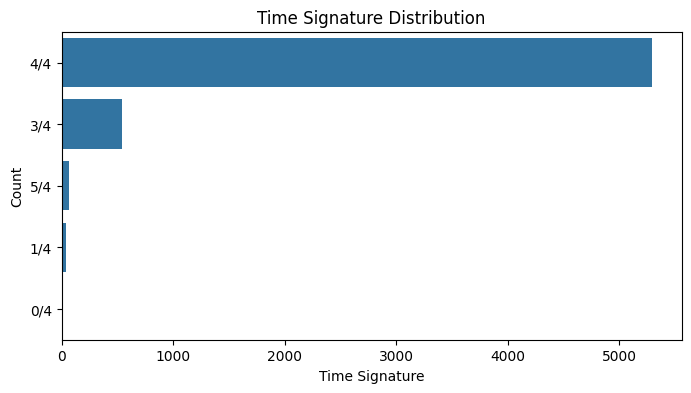

In [24]:
# plot time signature distribution
plt.figure(figsize=(8,4))
sns.countplot(data['time_signature'], order=data['time_signature'].value_counts().index)
plt.title('Time Signature Distribution')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.show()


The majority of the tracks are written in 4/4, the most common time signature in popular music. There is a small percentage of tracks written in 3/4.

We explore `track_popularity` distribution.

<Axes: xlabel='track_popularity', ylabel='Count'>

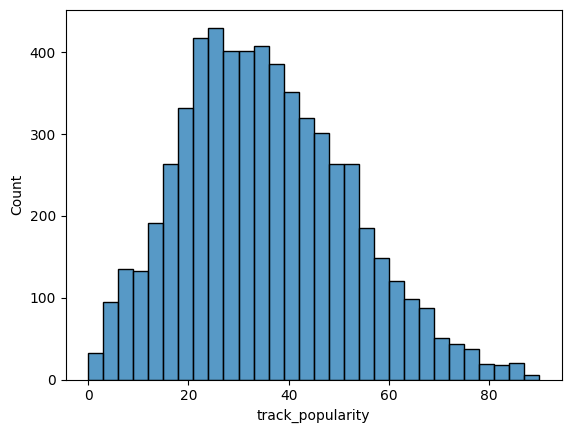

In [25]:
sns.histplot(data['track_popularity'], bins=30)

`track_popularity` is normally distributed. 

In [45]:
# 68 - 95 - 99.7 rule
def check_normality(data, feature):    
    sigma = data[feature].std()
    mu = data[feature].mean()
    #1 sigma
    pop_1sigma = data.query('(@data[@feature] > @mu - @sigma) & (@data[@feature] < @mu + @sigma)').shape[0]
    print(f"{(pop_1sigma / data.shape[0]) * 100:.2f}% of the tracks within 1 sigma")
    #2 sigma
    pop_2sigma = data.query('(@data[@feature] > @mu - 2*@sigma) & (@data[@feature] < @mu + 2*@sigma)').shape[0]
    print(f"{pop_2sigma / data.shape[0] * 100:.2f} of the tracks within 2 sigma")
    # 3 sigma
    pop_3sigma = data.query('(@data[@feature] > @mu - 3*@sigma) & (@data[@feature] < @mu + 3*@sigma)').shape[0]
    print(f"{pop_3sigma / data.shape[0] * 100:.2f} of the tracks within 3 sigma")

check_normality(data, 'track_popularity')


67.23% of the tracks within 1 sigma
96.29 of the tracks within 2 sigma
99.82 of the tracks within 3 sigma


We explore `danceability` distribution.

<Axes: xlabel='danceability', ylabel='Count'>

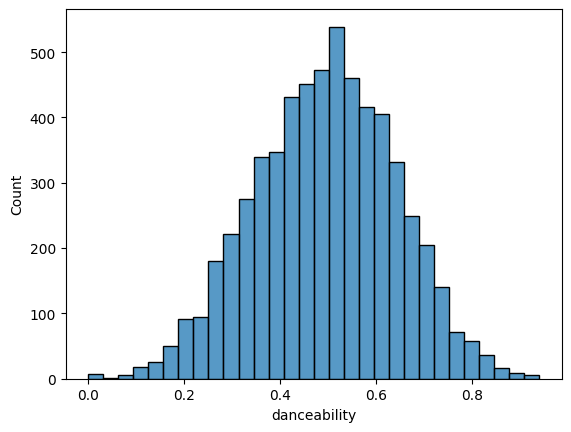

In [ ]:
sns.histplot(data['danceability'], bins=30)

In [46]:
check_normality(data, 'danceability')

67.24% of the tracks within 1 sigma
95.72 of the tracks within 2 sigma
99.85 of the tracks within 3 sigma


#### Exploring relationships between numerical values.

<Figure size 1200x1200 with 0 Axes>

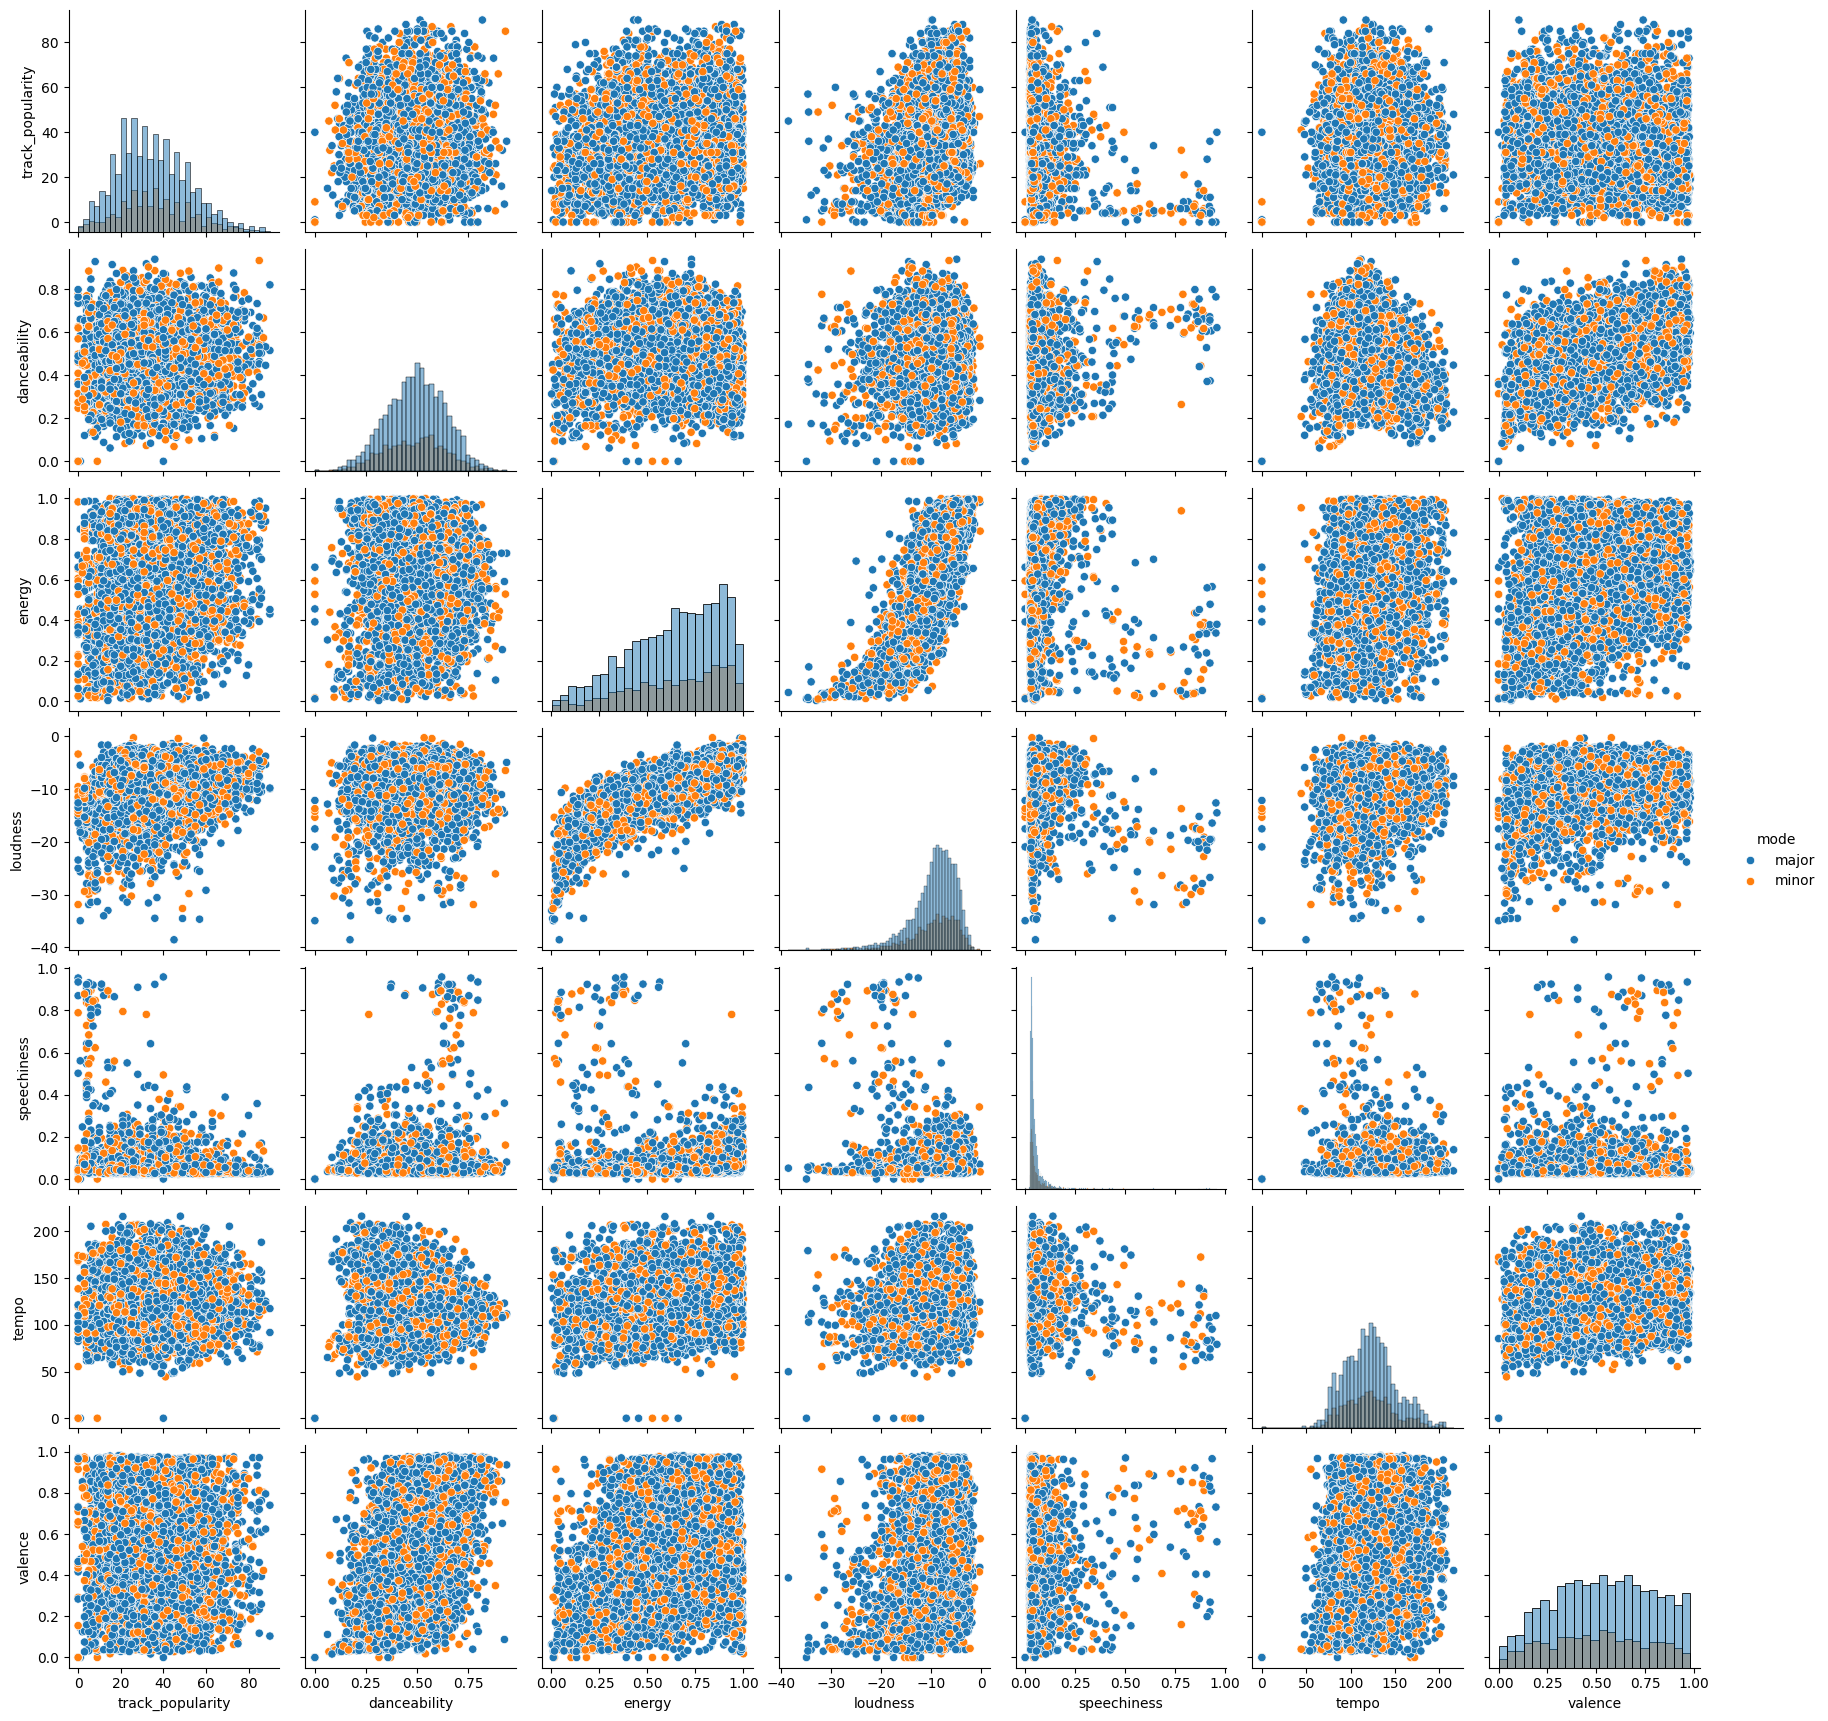

In [ ]:
# plot pairplot
plt.figure(figsize=(12, 12))
sns.pairplot(data=data[['track_popularity', 'danceability',
                        'energy', 'loudness', 'speechiness', 'tempo', 'valence', 'mode']],
             hue='mode',diag_kind="hist")
             
plt.show()